In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/plays2023.csv')
threshold = 30
off_counts = df['offense_idx'].value_counts()
def_counts = df['defense_idx'].value_counts()
valid_off_teams = off_counts[off_counts >= threshold].index
valid_def_teams = def_counts[def_counts >= threshold].index

In [2]:
df_filtered = df[df['offense_idx'].isin(valid_off_teams) & df['defense_idx'].isin(valid_def_teams)].copy()
print("Total drives after filtering:", len(df_filtered))
df_4th = df_filtered[df_filtered['down'] == 4].copy()
print("Total 4th down plays:", len(df_4th))

df_4th['fourth_down_success'] = (df_4th['offense_score'] > 0)
print("Unique classes in fourth_down_success:", df_4th['fourth_down_success'].unique())
print("Value counts:\n", df_4th['fourth_down_success'].value_counts())


Total drives after filtering: 151739
Total 4th down plays: 15854
Unique classes in fourth_down_success: [False  True]
Value counts:
 fourth_down_success
True     12342
False     3512
Name: count, dtype: int64


In [3]:
team_coeff = pd.read_csv('../data/team_coefficients2023.csv')

df_train = df_4th[df_4th['week'] < 9].copy()
df_test  = df_4th[df_4th['week'] > 8].copy()
print("Training 4th down plays (Model 2):", len(df_train))
print("Testing 4th down plays (Model 2):", len(df_test))

Training 4th down plays (Model 2): 9912
Testing 4th down plays (Model 2): 5942


In [4]:
off_map = team_coeff.set_index('team_id')['train_offense_coeff'].to_dict()
def_map = team_coeff.set_index('team_id')['train_defense_coeff'].to_dict()
df_4th = df_4th.merge(team_coeff[['team_id', 'train_offense_coeff']], 
                      left_on='offense_idx', right_on='team_id', how='left')
df_4th = df_4th.rename(columns={'train_offense_coeff': 'train_off_coef'})
df_4th = df_4th.drop(columns=['team_id'])

df_4th = df_4th.merge(team_coeff[['team_id', 'train_defense_coeff']], 
                      left_on='defense_idx', right_on='team_id', how='left')
df_4th = df_4th.rename(columns={'train_defense_coeff': 'train_def_coef'})
df_4th = df_4th.drop(columns=['team_id'])

# df_4th = df_4th.loc[:, ~df_4th.columns.duplicated()]

print(df_4th[['offense_idx', 'train_off_coef', 'defense_idx', 'train_def_coef']].head())

   offense_idx  train_off_coef  defense_idx  train_def_coef
0           80        0.199461          204        0.031409
1          204       -0.261431           80       -0.011000
2           80        0.199461          204        0.031409
3          204       -0.261431           80       -0.011000
4           80        0.199461          204        0.031409


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

df_train = df_4th[df_4th['week'] < 9].copy()
df_test  = df_4th[df_4th['week'] > 8].copy()
print("training 4th down plays :", len(df_train))
print("testing 4th down plays :", len(df_test))

df_train = df_train.dropna(subset=['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef'])
df_test  = df_test.dropna(subset=['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef'])
print("After dropping NaNs, training 4th down plays :", len(df_train))
print("After dropping NaNs, testing 4th down plays :", len(df_test))

X_train = df_train[['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef']]
X_test  = df_test[['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef']]
y_train = df_train['fourth_down_success']
y_test  = df_test['fourth_down_success']

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters for Model 2:", grid_search.best_params_)

training 4th down plays : 9912
testing 4th down plays : 5942
After dropping NaNs, training 4th down plays : 8076
After dropping NaNs, testing 4th down plays : 5821
Best parameters for Model 2: {'C': 0.001}


In [6]:
from sklearn.metrics import accuracy_score, mean_squared_error

model = LogisticRegression(max_iter=1000, C=grid_search.best_params_['C'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc2 = accuracy_score(y_test, y_pred)
rmse2 = np.sqrt(mean_squared_error(y_test, y_prob))
print("\nModel With Team Coefficients)")
print("Test Accuracy:", round(acc2, 3)*100, "%")
print("Test RMSE:", round(rmse2, 3))


Model With Team Coefficients)
Test Accuracy: 78.7 %
Test RMSE: 0.402


In [7]:
import pandas as pd

df_for_prediction = df_4th.dropna(subset=['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef']).copy()
print("Number of drives used for prediction:", len(df_for_prediction))

df_for_prediction['predicted_prob'] = model.predict_proba(
    df_for_prediction[['yards_to_goal', 'distance_to_goal', 'train_off_coef', 'train_def_coef']]
)[:, 1]

team_predictions = df_for_prediction.groupby('offense').agg(
    total_attempts=('fourth_down_success', 'count'),
    actual_conversion_rate=('fourth_down_success', 'mean'),
    avg_predicted_prob=('predicted_prob', 'mean')
).reset_index()

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'] * 100
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'] * 100

team_predictions['actual_conversion_rate'] = team_predictions['actual_conversion_rate'].map("{:.2f}%".format)
team_predictions['avg_predicted_prob'] = team_predictions['avg_predicted_prob'].map("{:.2f}%".format)

team_predictions.to_csv("../results/4th_Down_With_Team_Coeff/2023.csv", index=False)
print("Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions.csv'")
print(team_predictions.head())

Number of drives used for prediction: 13897
Team-level fourth down conversion predictions saved to 'team_fourth_down_conversion_predictions.csv'
             offense  total_attempts actual_conversion_rate avg_predicted_prob
0  Abilene Christian              21                 95.24%             77.10%
1          Air Force              79                 70.89%             80.40%
2              Akron             111                 68.47%             75.59%
3            Alabama             110                 84.55%             80.29%
4          App State              97                 77.32%             81.13%


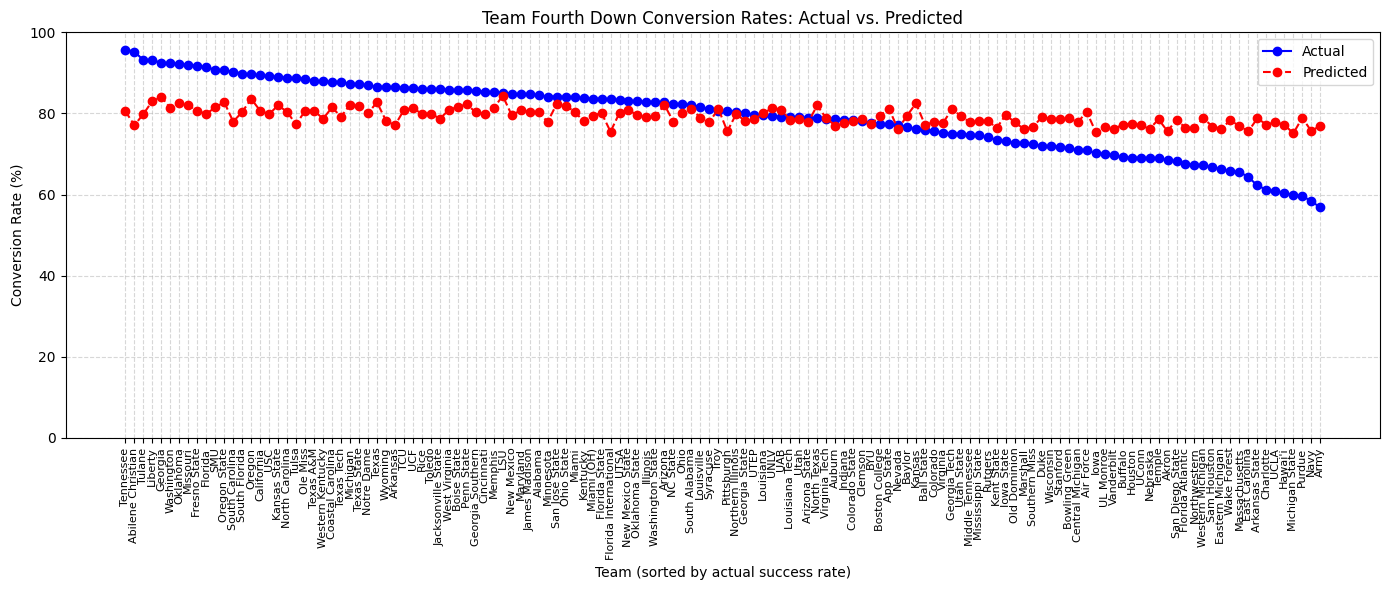

In [8]:
import matplotlib.pyplot as plt
import numpy as np

df_team = team_predictions.copy()

df_team['actual_conversion_rate_numeric'] = df_team['actual_conversion_rate'].str.rstrip('%').astype(float)
df_team['avg_predicted_prob_numeric'] = df_team['avg_predicted_prob'].str.rstrip('%').astype(float)

df_team = df_team.sort_values(by='actual_conversion_rate_numeric', ascending=False).reset_index(drop=True)

x = np.arange(len(df_team))

plt.figure(figsize=(14, 6))
plt.plot(x, df_team['actual_conversion_rate_numeric'], color='blue', linestyle='-', marker='o', label='Actual')
plt.plot(x, df_team['avg_predicted_prob_numeric'], color='red', linestyle='--', marker='o', label='Predicted')

plt.xlabel("Team (sorted by actual success rate)")
plt.ylabel("Conversion Rate (%)")
plt.title("Team Fourth Down Conversion Rates: Actual vs. Predicted")
plt.xticks(x, df_team['offense'], rotation=90, fontsize=8)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()